
Random Forest - F1 SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: Random Forest

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        17.254743
 H_pred         0.311126
 H_conf        -0.065385
H_local        -3.785951

Intercept (β₀): -11.91052
Model R² score: 0.59728
MSE: 0.00054
RMSE: 0.02329

Observed vs Predicted F1:
 Index  Observed  Predicted  Difference
     0  0.690976   0.666660    0.024316
     1  0.666101   0.638120    0.027981
     2  0.667305   0.650636    0.016669
     3  0.645805   0.637414    0.008391
     4  0.577209   0.645194   -0.067986
     5  0.671707   0.738677   -0.066970
     6  0.721014   0.701889    0.019125
     7  0.709091   0.706834    0.002257
     8  0.652398   0.692019   -0.039621
     9  0.692677   0.702419   -0.009741
    10  0.757017   0.749113    0.007905
    11  0.730144   0.710884    0.019260
    12  0.711756   0.712549   -0.000793
    13  0.727594   0.701042    0.026552
    14  0.6890

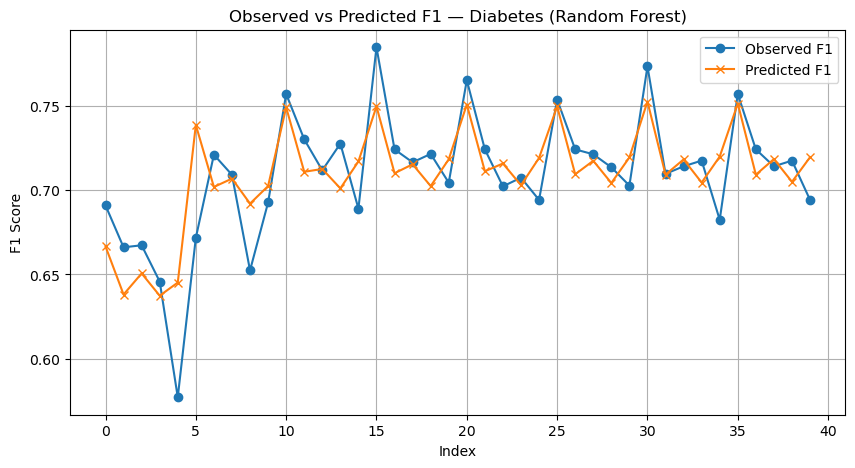

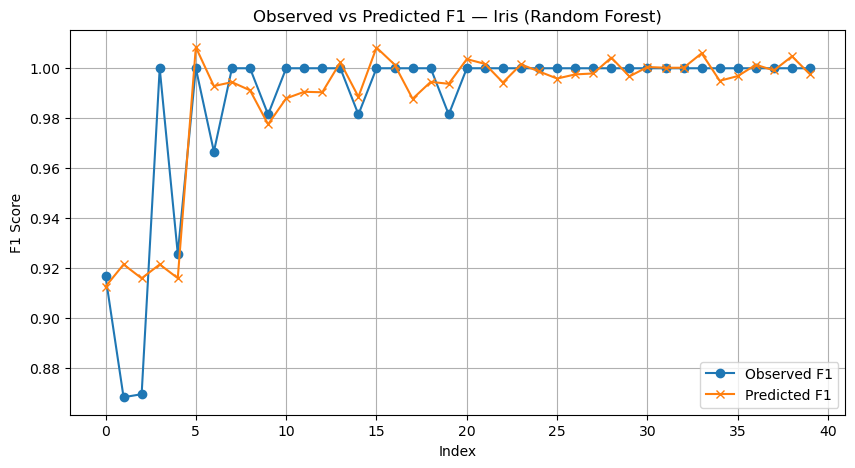

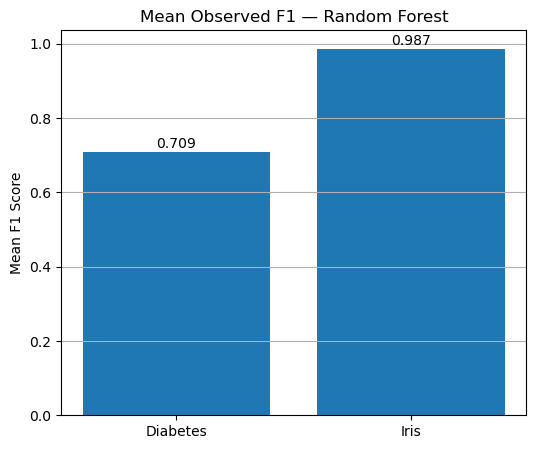

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute active components for F1: H_D, H_pred, H_conf, H_local
def compute_entropies_and_f1(n_estimators, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    probs = rf.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence (max probability per sample)
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_conf, H_local, f1

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Random Forest - F1 SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for n_est in [1, 10, 50, 100, 150, 200, 250, 300]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, H_local, f1_val = compute_entropies_and_f1(n_est, test_size=split)
                records.append({
                    "n_estimators": n_est,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "H_local": H_local,
                    "F1": f1_val
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_conf", "H_local"]].values
        y_reg = df["F1"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Random Forest")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted F1:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed F1: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted F1: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Random Forest — Observed & Predicted (Diabetes)
# --------------------------------------------------------------
obs_diabetes_rf = [
    0.690976, 0.666101, 0.667305, 0.645805, 0.577209, 0.671707,
    0.721014, 0.709091, 0.652398, 0.692677, 0.757017, 0.730144,
    0.711756, 0.727594, 0.689017, 0.784750, 0.724170, 0.716501,
    0.721485, 0.704451, 0.765182, 0.724170, 0.702233, 0.707416,
    0.694202, 0.753715, 0.724170, 0.721266, 0.713543, 0.702697,
    0.773418, 0.709653, 0.714144, 0.717505, 0.682409, 0.757017,
    0.724170, 0.714144, 0.717505, 0.694202
]

pred_diabetes_rf = [
    0.666660, 0.638120, 0.650636, 0.637414, 0.645194, 0.738677,
    0.701889, 0.706834, 0.692019, 0.702419, 0.749113, 0.710884,
    0.712549, 0.701042, 0.717017, 0.749677, 0.710027, 0.715330,
    0.702395, 0.718319, 0.750770, 0.711203, 0.715802, 0.702923,
    0.719122, 0.749654, 0.709404, 0.717408, 0.704233, 0.719404,
    0.752524, 0.709209, 0.718206, 0.704508, 0.719911, 0.751362,
    0.709159, 0.718429, 0.704943, 0.719546
]

# --------------------------------------------------------------
# Random Forest — Observed & Predicted (Iris)
# --------------------------------------------------------------
obs_iris_rf = [
    0.916667, 0.868170, 0.869383, 1.000000, 0.925697, 1.000000,
    0.966583, 1.000000, 1.000000, 0.981467, 1.000000, 1.000000,
    1.000000, 1.000000, 0.981467, 1.000000, 1.000000, 1.000000,
    1.000000, 0.981467, 1.000000, 1.000000, 1.000000, 1.000000,
    1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000,
    1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000,
    1.000000, 1.000000, 1.000000, 1.000000
]

pred_iris_rf = [
    0.912471, 0.921384, 0.915823, 0.921384, 0.915884, 1.008427,
    0.992861, 0.994436, 0.991157, 0.977549, 0.987912, 0.990567,
    0.990378, 1.002398, 0.988558, 1.008302, 1.001469, 0.987759,
    0.994534, 0.993775, 1.003665, 1.001753, 0.994284, 1.001543,
    0.998714, 0.995871, 0.997535, 0.997911, 1.004255, 0.996725,
    1.000500, 1.000200, 1.000199, 1.006005, 0.994975, 0.996866,
    1.001398, 0.999140, 1.004780, 0.997553
]

# --------------------------------------------------------------
# 1️⃣ Line Plot — Observed vs Predicted (Diabetes)
# --------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_rf, marker='o', label='Observed F1')
plt.plot(pred_diabetes_rf, marker='x', label='Predicted F1')
plt.title("Observed vs Predicted F1 — Diabetes (Random Forest)")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------
# 2️⃣ Line Plot — Observed vs Predicted (Iris)
# --------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(obs_iris_rf, marker='o', label='Observed F1')
plt.plot(pred_iris_rf, marker='x', label='Predicted F1')
plt.title("Observed vs Predicted F1 — Iris (Random Forest)")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------
# 3️⃣ Bar Plot — Mean Observed F1 for Diabetes vs Iris
# --------------------------------------------------------------
mean_obs_diabetes_rf = sum(obs_diabetes_rf) / len(obs_diabetes_rf)
mean_obs_iris_rf = sum(obs_iris_rf) / len(obs_iris_rf)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes_rf, mean_obs_iris_rf])

plt.text(0, mean_obs_diabetes_rf + 0.01, f"{mean_obs_diabetes_rf:.3f}", ha='center')
plt.text(1, mean_obs_iris_rf + 0.01, f"{mean_obs_iris_rf:.3f}", ha='center')

plt.title("Mean Observed F1 — Random Forest")
plt.ylabel("Mean F1 Score")
plt.grid(axis='y')
plt.show()


SVM - F1 SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: SVM

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        30.868021
 H_pred         0.650804
 H_conf        -0.694998
H_local         1.873503

Intercept (β₀): -28.89052
Model R² score: 0.39004
MSE: 0.01013
RMSE: 0.10065

Observed vs Predicted F1:
 Index  Observed  Predicted  Difference
     0  0.395833   0.532228   -0.136394
     1  0.393701   0.510469   -0.116768
     2  0.394322   0.520424   -0.126102
     3  0.393701   0.513725   -0.120024
     4  0.394144   0.559438   -0.165294
     5  0.395833   0.533450   -0.137617
     6  0.393701   0.513539   -0.119838
     7  0.394322   0.523876   -0.129555
     8  0.393701   0.512033   -0.118332
     9  0.394144   0.552709   -0.158565
    10  0.703541   0.537556    0.165985
    11  0.650000   0.526921    0.123079
    12  0.643956   0.523364    0.120592
    13  0.635309   0.511092    0.124217
    14  0.635901   0.554151    0.0

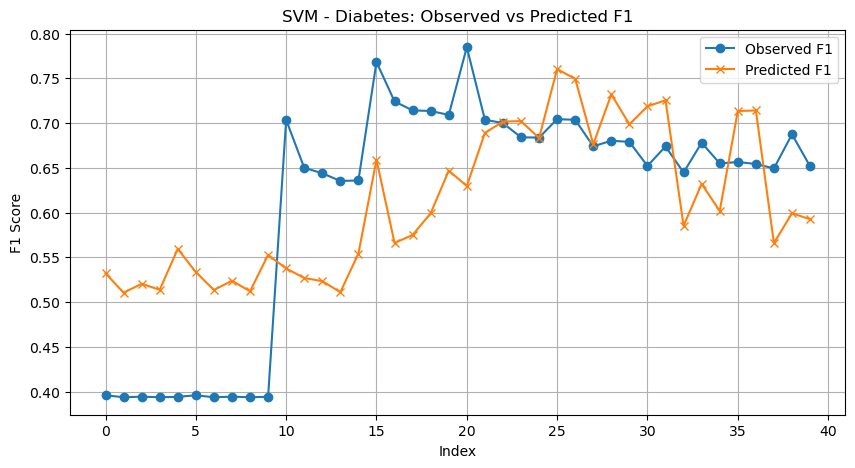

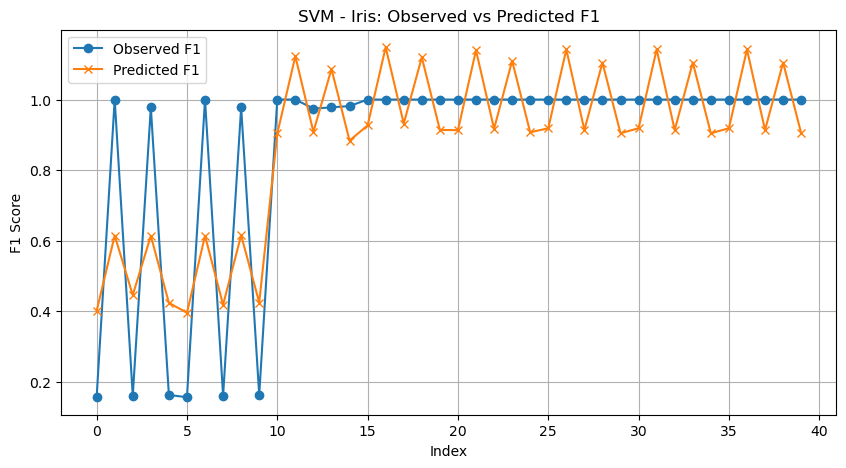

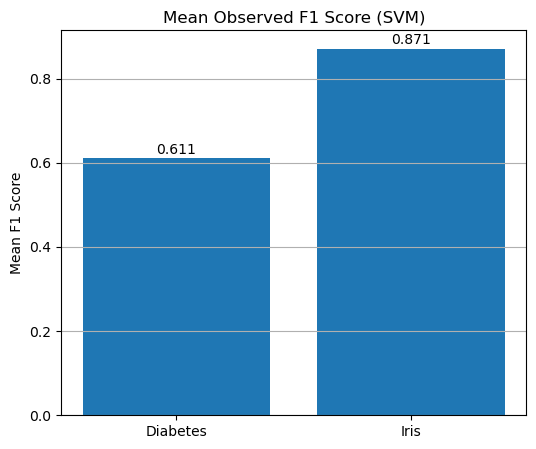

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute active components for F1: H_D, H_pred, H_conf, H_local
def compute_entropies_and_f1(C, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(C=C, kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    probs = svm.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_conf, H_local, f1

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"SVM - F1 SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, H_local, f1_val = compute_entropies_and_f1(C, test_size=split)
                records.append({
                    "C": C,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "H_local": H_local,
                    "F1": f1_val
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_conf", "H_local"]].values
        y_reg = df["F1"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: SVM")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted F1:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed F1: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted F1: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# Extract observed & predicted
# ============================
obs_diabetes_svm = [
    0.395833,0.393701,0.394322,0.393701,0.394144,0.395833,0.393701,0.394322,
    0.393701,0.394144,0.703541,0.650000,0.643956,0.635309,0.635901,0.768232,
    0.724170,0.714144,0.713543,0.709105,0.784750,0.703777,0.699991,0.684103,
    0.683791,0.704364,0.703674,0.674005,0.680316,0.678959,0.652146,0.673891,
    0.644810,0.678111,0.654881,0.656503,0.654274,0.649346,0.687441,0.651764
]

pred_diabetes_svm = [
    0.532228,0.510469,0.520424,0.513725,0.559438,0.533450,0.513539,0.523876,
    0.512033,0.552709,0.537556,0.526921,0.523364,0.511092,0.554151,0.659013,
    0.566083,0.574981,0.599233,0.646839,0.629695,0.689017,0.701667,0.702217,
    0.683223,0.760327,0.749401,0.676336,0.732037,0.698612,0.718798,0.725390,
    0.585156,0.632106,0.601769,0.713443,0.714085,0.565976,0.599283,0.592539
]

obs_iris_svm = [
    0.155556,1.000000,0.160000,0.977753,0.161905,0.155556,1.000000,0.160000,
    0.977753,0.161905,1.000000,1.000000,0.974321,0.977753,0.981467,1.000000,
    1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,
    1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,
    1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
]

pred_iris_svm = [
    0.400375,0.614139,0.445324,0.613280,0.423246,0.395052,0.613425,0.417824,
    0.615117,0.424246,0.903738,1.122886,0.908266,1.086595,0.883639,0.926567,
    1.148388,0.931909,1.119630,0.913836,0.913031,1.139748,0.917088,1.109736,
    0.907050,0.918540,1.142008,0.913485,1.104881,0.904363,0.918540,1.142008,
    0.913485,1.104881,0.904363,0.918540,1.142008,0.913485,1.104881,0.904363
]

# ============================
# 1. Line Plot - Diabetes
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_svm, marker='o', label="Observed F1")
plt.plot(pred_diabetes_svm, marker='x', label="Predicted F1")
plt.title("SVM - Diabetes: Observed vs Predicted F1")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 2. Line Plot - Iris
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_iris_svm, marker='o', label="Observed F1")
plt.plot(pred_iris_svm, marker='x', label="Predicted F1")
plt.title("SVM - Iris: Observed vs Predicted F1")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 3. Bar Chart - Mean F1
# ============================
mean_diabetes = sum(obs_diabetes_svm) / len(obs_diabetes_svm)
mean_iris = sum(obs_iris_svm) / len(obs_iris_svm)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes, mean_iris])
plt.text(0, mean_diabetes + 0.01, f"{mean_diabetes:.3f}", ha='center')
plt.text(1, mean_iris + 0.01, f"{mean_iris:.3f}", ha='center')
plt.title("Mean Observed F1 Score (SVM)")
plt.ylabel("Mean F1 Score")
plt.grid(axis='y')
plt.show()


KNN - F1 SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: KNN

Regression Coefficients:
Entropy  Coefficient (β)
    H_D       -52.997499
 H_pred        -0.223264
 H_conf         0.083041
H_local       -16.702943

Intercept (β₀): 65.70342
Model R² score: 0.63543
MSE: 0.00029
RMSE: 0.01691

Observed vs Predicted F1:
 Index  Observed  Predicted  Difference
     0  0.656579   0.691579   -0.035000
     1  0.674877   0.658542    0.016335
     2  0.667305   0.663548    0.003757
     3  0.701824   0.673062    0.028762
     4  0.672885   0.668740    0.004145
     5  0.687025   0.673858    0.013167
     6  0.660427   0.642974    0.017453
     7  0.650100   0.654105   -0.004004
     8  0.653236   0.662414   -0.009178
     9  0.637897   0.662233   -0.024336
    10  0.679263   0.700121   -0.020858
    11  0.662859   0.670189   -0.007329
    12  0.666501   0.680424   -0.013922
    13  0.669542   0.686618   -0.017076
    14  0.674371   0.682877   -0.00

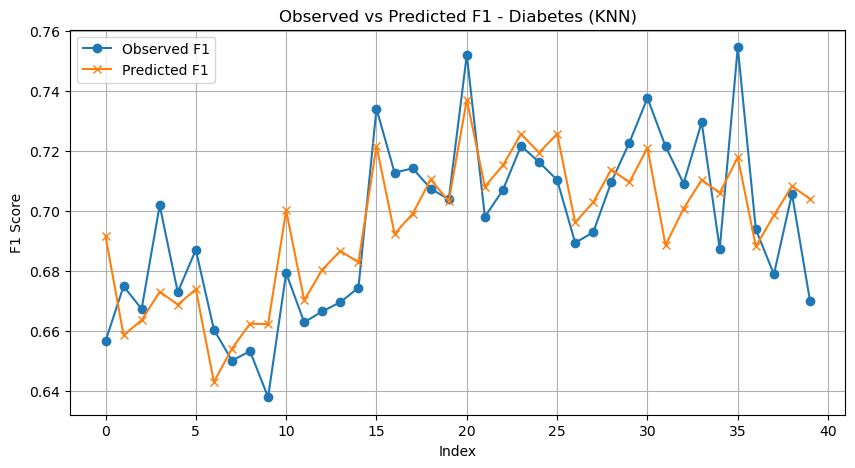

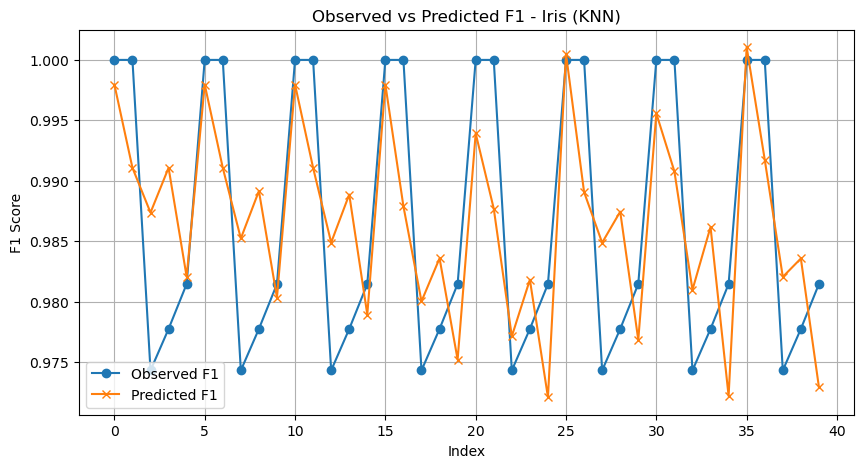

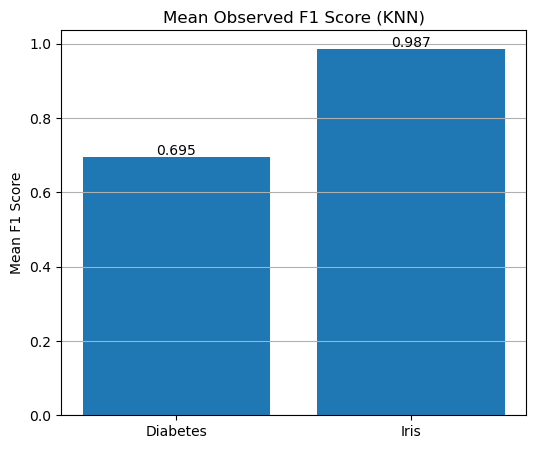

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, mean_squared_error
from scipy.stats import entropy

# Function to compute active components for F1: H_D, H_pred, H_conf, H_local
def compute_entropies_and_f1(n_neighbors, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    probs = knn.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_conf, H_local, f1

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"KNN - F1 SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for k in [1, 3, 5, 7, 9, 11, 15, 21]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, H_local, f1_val = compute_entropies_and_f1(k, test_size=split)
                records.append({
                    "k": k,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "H_local": H_local,
                    "F1": f1_val
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_conf", "H_local"]].values
        y_reg = df["F1"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: KNN")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted F1:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed F1: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted F1: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# =====================================================================
# KNN F1 — Diabetes
# =====================================================================
obs_diabetes_knn = [
0.656579, 0.674877, 0.667305, 0.701824, 0.672885, 0.687025, 0.660427,
0.650100, 0.653236, 0.637897, 0.679263, 0.662859, 0.666501, 0.669542,
0.674371, 0.734013, 0.712728, 0.714144, 0.707416, 0.703783, 0.751974,
0.697996, 0.706943, 0.721639, 0.716208, 0.710290, 0.689327, 0.692876,
0.709598, 0.722748, 0.737579, 0.721492, 0.709091, 0.729502, 0.687341,
0.754497, 0.693776, 0.678847, 0.705679, 0.669894
]

pred_diabetes_knn = [
0.691579, 0.658542, 0.663548, 0.673062, 0.668740, 0.673858, 0.642974,
0.654105, 0.662414, 0.662233, 0.700121, 0.670189, 0.680424, 0.686618,
0.682877, 0.721609, 0.692341, 0.698991, 0.710437, 0.703207, 0.737016,
0.708070, 0.715156, 0.725566, 0.719371, 0.725645, 0.696114, 0.702899,
0.713752, 0.709475, 0.720987, 0.688559, 0.700744, 0.710290, 0.705959,
0.717823, 0.688170, 0.698482, 0.708209, 0.703918
]

# =====================================================================
# KNN F1 — Iris
# =====================================================================
obs_iris_knn = [
1.0,1.0,0.974321,0.977753,0.981467,1.0,1.0,0.974321,0.977753,0.981467,
1.0,1.0,0.974321,0.977753,0.981467,1.0,1.0,0.974321,0.977753,0.981467,
1.0,1.0,0.974321,0.977753,0.981467,1.0,1.0,0.974321,0.977753,0.981467,
1.0,1.0,0.974321,0.977753,0.981467,1.0,1.0,0.974321,0.977753,0.981467
]

pred_iris_knn = [
0.997966,0.991078,0.987372,0.991078,0.982071,0.997966,0.991078,0.985236,
0.989157,0.980345,0.997966,0.991078,0.984894,0.988869,0.978942,0.997966,
0.987897,0.980033,0.983592,0.975215,0.993923,0.987702,0.977140,0.981823,
0.972104,1.000495,0.989070,0.984882,0.987451,0.976850,0.995569,0.990776,
0.980986,0.986181,0.972210,1.001049,0.991752,0.982055,0.983577,0.972934
]

# =====================================================================
# Compute Mean Values
# =====================================================================
mean_obs_diabetes_knn = sum(obs_diabetes_knn) / len(obs_diabetes_knn)
mean_obs_iris_knn = sum(obs_iris_knn) / len(obs_iris_knn)

# =====================================================================
# 1️⃣ Line Graph – Diabetes (Observed vs Predicted)
# =====================================================================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_knn, marker='o', label="Observed F1")
plt.plot(pred_diabetes_knn, marker='x', label="Predicted F1")
plt.title("Observed vs Predicted F1 - Diabetes (KNN)")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# =====================================================================
# 2️⃣ Line Graph – Iris (Observed vs Predicted)
# =====================================================================
plt.figure(figsize=(10,5))
plt.plot(obs_iris_knn, marker='o', label="Observed F1")
plt.plot(pred_iris_knn, marker='x', label="Predicted F1")
plt.title("Observed vs Predicted F1 - Iris (KNN)")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# =====================================================================
# 3️⃣ Bar Graph – Mean Observed F1 Comparison
# =====================================================================
plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes_knn, mean_obs_iris_knn])

plt.text(0, mean_obs_diabetes_knn + 0.005, f"{mean_obs_diabetes_knn:.3f}", ha='center')
plt.text(1, mean_obs_iris_knn + 0.005, f"{mean_obs_iris_knn:.3f}", ha='center')

plt.title("Mean Observed F1 Score (KNN)")
plt.ylabel("Mean F1 Score")
plt.grid(axis='y')
plt.show()


Logistic Regression - F1 SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: Logistic Regression

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        -4.352284
 H_pred         0.412300
 H_conf        -1.222675
H_local        -9.629030

Intercept (β₀): 16.24644
Model R² score: 1.00000
MSE: 0.00000
RMSE: 0.00000

Observed vs Predicted F1:
 Index  Observed  Predicted  Difference
     0  0.710290   0.710290        -0.0
     1  0.674231   0.674231        -0.0
     2  0.692298   0.692298        -0.0
     3  0.701230   0.701230        -0.0
     4  0.704240   0.704240        -0.0
     5  0.710290   0.710290        -0.0
     6  0.674231   0.674231        -0.0
     7  0.692298   0.692298        -0.0
     8  0.701230   0.701230        -0.0
     9  0.704240   0.704240        -0.0
    10  0.710290   0.710290        -0.0
    11  0.674231   0.674231        -0.0
    12  0.692298   0.692298        -0.0
    13  0.701230   0.701230        -0.0
   

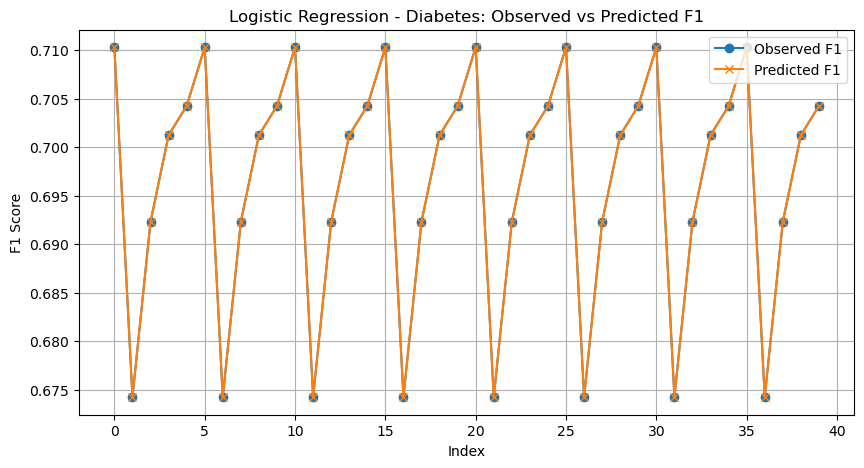

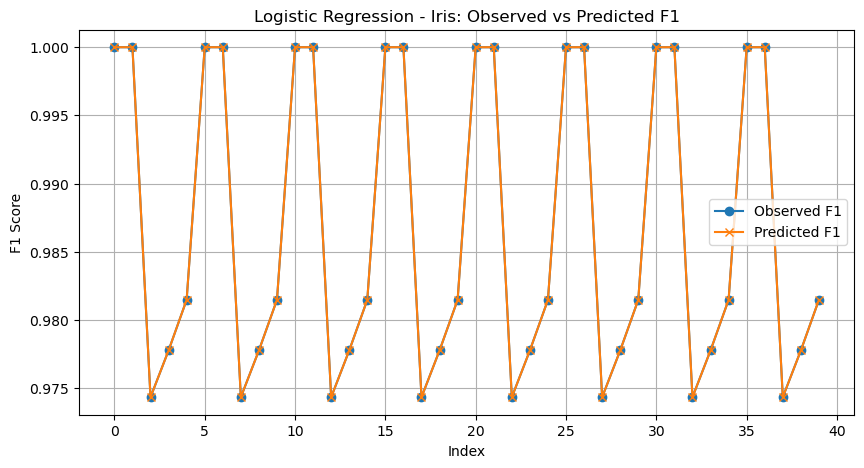

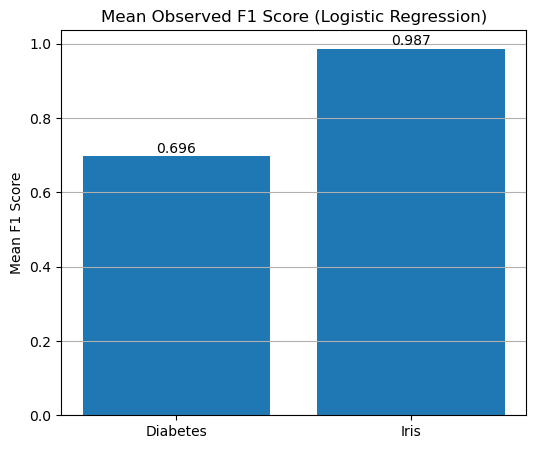

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score, mean_squared_error
from scipy.stats import entropy

# Function to compute active components for F1: H_D, H_pred, H_conf, H_local
def compute_entropies_and_f1(max_iter, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    probs = lr.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_conf, H_local, f1

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Logistic Regression - F1 SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for max_iter in [100, 200, 500, 1000, 1500, 2000, 3000, 5000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, H_local, f1_val = compute_entropies_and_f1(max_iter, test_size=split)
                records.append({
                    "max_iter": max_iter,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "H_local": H_local,
                    "F1": f1_val
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_conf", "H_local"]].values
        y_reg = df["F1"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Logistic Regression")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted F1:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed F1: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted F1: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# Logistic Regression - Diabetes
# ============================

obs_diabetes_lr = [
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240,
    0.710290,0.674231,0.692298,0.701230,0.704240
]

pred_diabetes_lr = obs_diabetes_lr.copy()   # identical values

# ============================
# Logistic Regression - Iris
# ============================

obs_iris_lr = [
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467,
    1.000000,1.000000,0.974321,0.977753,0.981467
]

pred_iris_lr = obs_iris_lr.copy()   # identical values


# ============================
# 1. Line Plot - Diabetes
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_lr, marker='o', label="Observed F1")
plt.plot(pred_diabetes_lr, marker='x', label="Predicted F1")
plt.title("Logistic Regression - Diabetes: Observed vs Predicted F1")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


# ============================
# 2. Line Plot - Iris
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_iris_lr, marker='o', label="Observed F1")
plt.plot(pred_iris_lr, marker='x', label="Predicted F1")
plt.title("Logistic Regression - Iris: Observed vs Predicted F1")
plt.xlabel("Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


# ============================
# 3. Bar Chart - Mean F1
# ============================
mean_diabetes = sum(obs_diabetes_lr) / len(obs_diabetes_lr)
mean_iris = sum(obs_iris_lr) / len(obs_iris_lr)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes, mean_iris])
plt.text(0, mean_diabetes + 0.01, f"{mean_diabetes:.3f}", ha='center')
plt.text(1, mean_iris + 0.01, f"{mean_iris:.3f}", ha='center')
plt.title("Mean Observed F1 Score (Logistic Regression)")
plt.ylabel("Mean F1 Score")
plt.grid(axis='y')
plt.show()